# KS Metric

Kolmogorov-Smirnov metric (ks metric) is derived from K-S test. K-S test measures the distance between two plotted cumulative distribution functions (CDF).   
To use it as a metric for classification machine learning problem we see the distance of plotted CDF of target and non-target.  
The model that produces the greatest amount of separability between target and non-target distribution would be considered the better model.

In [69]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [8]:
# make sample dataset
X, y = make_classification(n_samples=1000, class_sep=0.5, random_state=0) # 1000 samples with 20 features
X[:2], y[:2]

(array([[-1.06377997,  0.67640868,  1.06935647, -0.21758002,  0.46021477,
         -0.39916689, -0.07918751,  1.20938491, -0.78531472, -0.17218611,
         -1.08535744, -0.49311895,  0.11523863,  0.06405769, -0.50655382,
         -0.52749607, -0.0741832 , -0.35562842,  1.05721416, -0.40259159],
        [ 0.0708476 , -1.69528125,  2.44944917, -0.5304942 , -0.93296221,
          2.86520354,  2.43572851, -1.61850016,  1.30071691,  0.34840246,
          0.54493439, -0.27467589, -0.0181811 , -0.19210097, -0.24468054,
          0.9716812 , -1.79204799,  0.01708348, -0.37566904, -0.12323644]]),
 array([0, 1]))

In [20]:
# split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)
print(f"{X_train.shape = }\n{y_train.shape = }\n\n{X_test.shape = }\n{y_test.shape = }\n ")

X_train.shape = (670, 20)
y_train.shape = (670,)

X_test.shape = (330, 20)
y_test.shape = (330,)

In [10]:
# simple Logistic Model
model = LogisticRegression(random_state=23)
model.fit(X_train, y_train)

LogisticRegression(random_state=23)

In [31]:
# predictions
y_train_pred = model.predict_proba(X_train)[:,1]
y_test_pred = model.predict_proba(X_test)[:,1]

# KS Table

## Group into Deciles

In [50]:
list(range(0,10,1))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [64]:
df = pd.DataFrame()
df["score"] = y_test_pred
# one hot encoding the dependent variable
df["class_0"] = 1 - y_test
df["class_1"] = y_test

# bucket/group prediction after ordering them
df["bucket"] = pd.qcut(df.score.rank(method="first"), 10, labels=list(range(0,10,1)))

df.head()

,score,class_0,class_1,bucket
0,0.152806,1,0,1
1,0.027964,1,0,0
2,0.082966,0,1,0
3,0.195532,1,0,2
4,0.952148,0,1,8


### Goods-Bads Distribution

In [66]:
grouped = df.groupby("bucket", as_index=False)

ks_table = pd.DataFrame()
ks_table["min_score"] = grouped.min().score
ks_table["max_score"] = grouped.max().score
ks_table["n_class_0"] = grouped.sum().class_0
ks_table["n_class_1"] = grouped.sum().class_1
ks_table["n_total"] = ks_table.n_class_0 + ks_table.n_class_1

ks_table

,min_score,max_score,n_class_0,n_class_1,n_total
0,0.003576,0.102894,29,4,33
1,0.109209,0.190817,28,5,33
2,0.191658,0.256742,27,6,33
3,0.257778,0.353945,28,5,33
4,0.356250,0.463956,18,15,33
5,0.466864,0.670035,14,19,33
6,0.682374,0.830071,3,30,33
7,0.831854,0.909685,5,28,33
8,0.912608,0.973338,2,31,33
9,0.975036,0.998577,4,29,33


<AxesSubplot:>

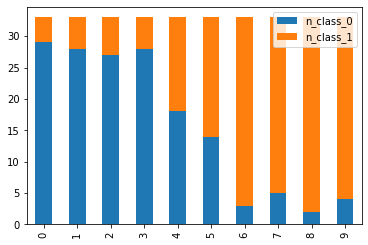

In [67]:
ks_table[['n_class_0', 'n_class_1',]].plot.bar(stacked=True)

In [73]:
count_class_0 = df.class_0.sum()
count_class_1 = df.class_1.sum()

ks_table["cs_class_0"] = ((ks_table.n_class_0 / count_class_0).cumsum() * 100)
ks_table["cs_class_1"] = ((ks_table.n_class_1 / count_class_1).cumsum() * 100)

ks_table["cs_diff"] = ks_table["cs_class_0"] - ks_table["cs_class_1"]

ks_table

,min_score,max_score,n_class_0,n_class_1,n_total,cs_class_0,cs_class_1,cs_diff
0,0.003576,0.102894,29,4,33,18.354430,2.325581,16.028849
1,0.109209,0.190817,28,5,33,36.075949,5.232558,30.843391
2,0.191658,0.256742,27,6,33,53.164557,8.720930,44.443627
3,0.257778,0.353945,28,5,33,70.886076,11.627907,59.258169
4,0.356250,0.463956,18,15,33,82.278481,20.348837,61.929644
5,0.466864,0.670035,14,19,33,91.139241,31.395349,59.743892
6,0.682374,0.830071,3,30,33,93.037975,48.837209,44.200765
7,0.831854,0.909685,5,28,33,96.202532,65.116279,31.086253
8,0.912608,0.973338,2,31,33,97.468354,83.139535,14.328820
9,0.975036,0.998577,4,29,33,100.000000,100.000000,0.000000


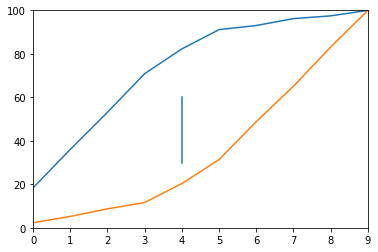

In [97]:
fig, ax = plt.subplots(1,1)
ax.plot(ks_table["cs_class_0"])
ax.plot(ks_table["cs_class_1"])
ax.axvline(4, 0.3, 0.6)
ax.set_xlim([0.0, 9])
ax.set_ylim([0.0, 100])
plt.show()